Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_burn_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_cab_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_calm_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_came_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_cause_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_chain_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_chair_angry.wav  
  inflating: TESS Toronto emotio

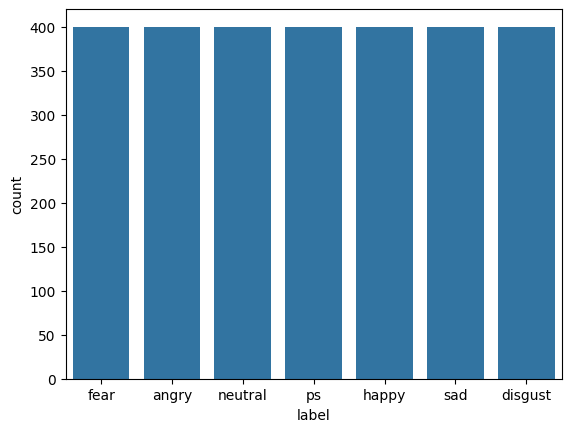

In [1]:
# Install Kaggle API and download the dataset
!pip install -q kaggle
!mkdir ~/.kaggle/

# Provide your Kaggle API key here (replace 'YOUR_KAGGLE_USERNAME' and 'YOUR_KAGGLE_KEY' with your actual Kaggle credentials)
with open('kaggle.json', 'w') as f:
    f.write('{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}')

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Initialize lists to hold file paths and labels
paths = []
labels = []

# Walk through the dataset directory and collect file paths and corresponding labels
for dirname, _, filenames in os.walk('/content/tess toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split('.')[0].lower()
        labels.append(label)

print('Dataset is loaded')
df = pd.DataFrame({'speech': paths, 'label': labels})
print(df.head())

# Visualize the distribution of labels
sns.countplot(data=df, x='label')
plt.show()


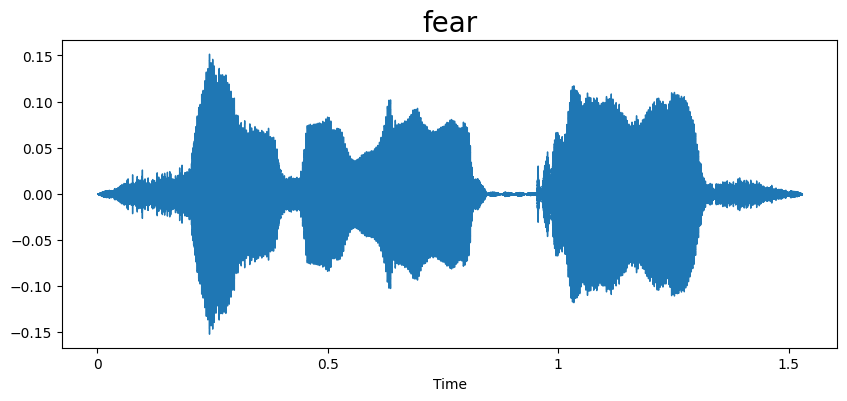

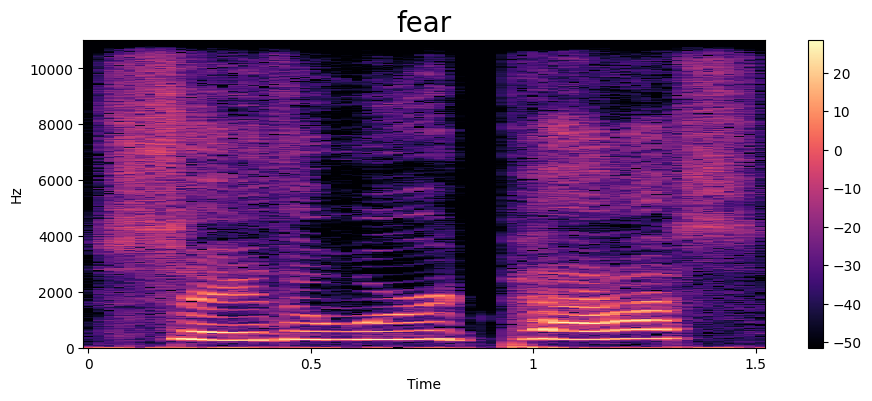

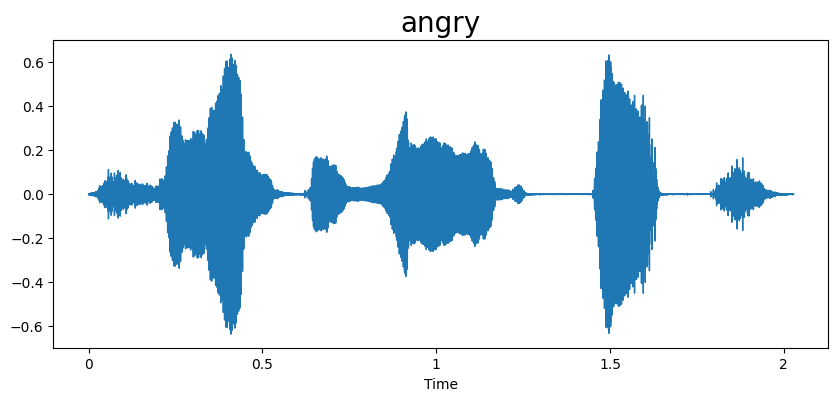

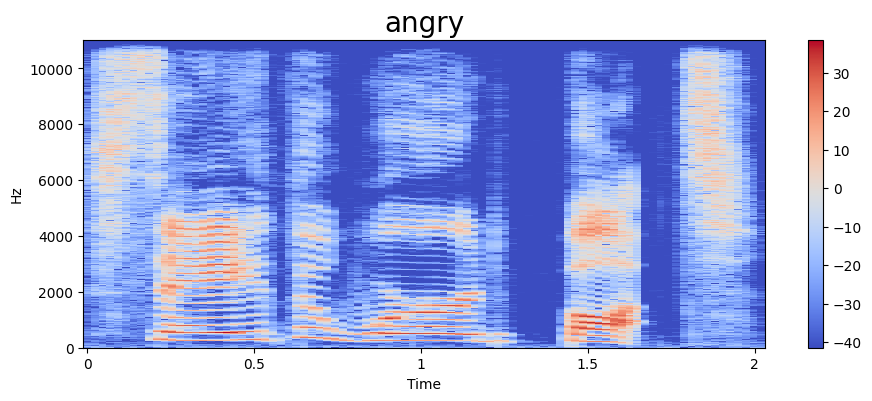

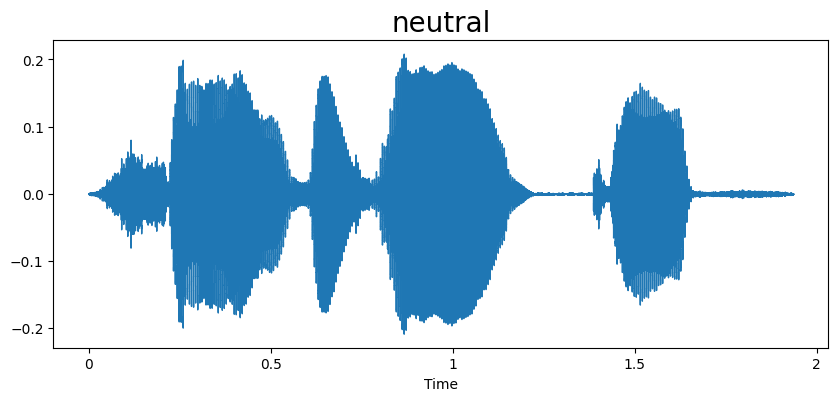

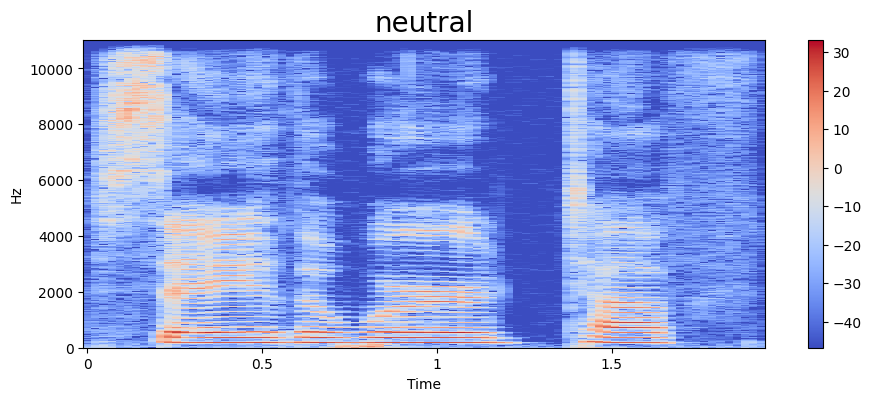

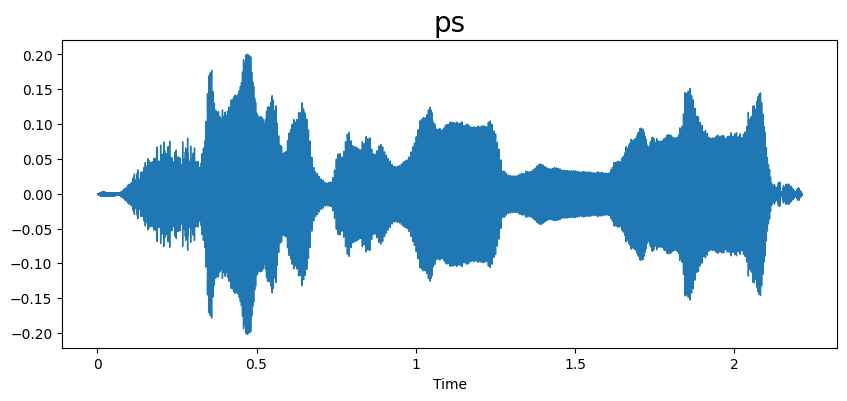

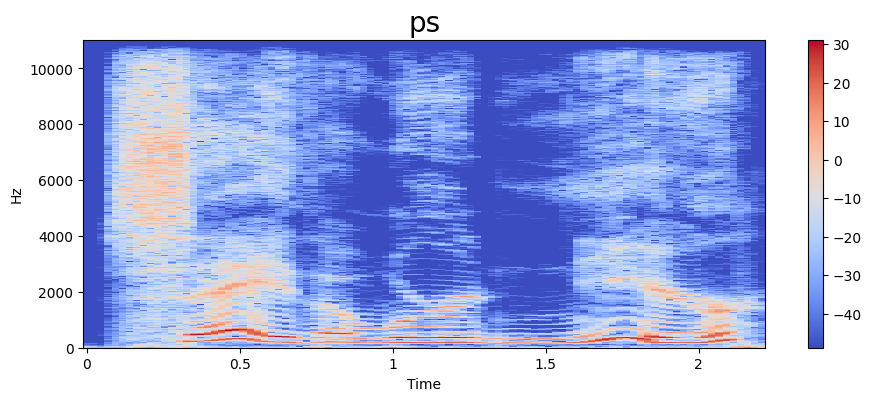

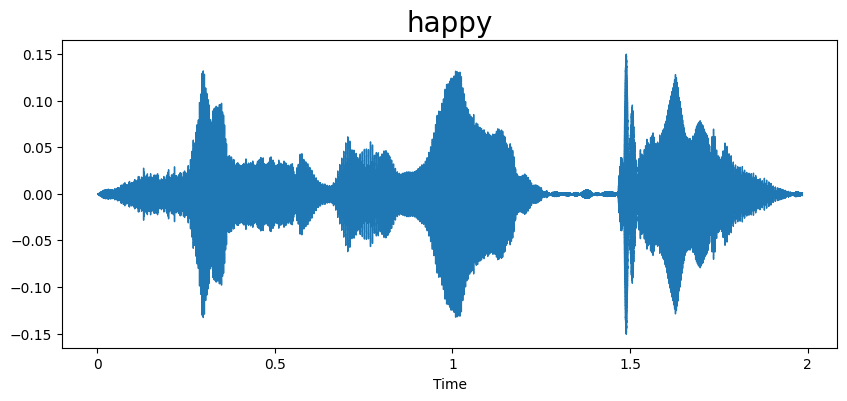

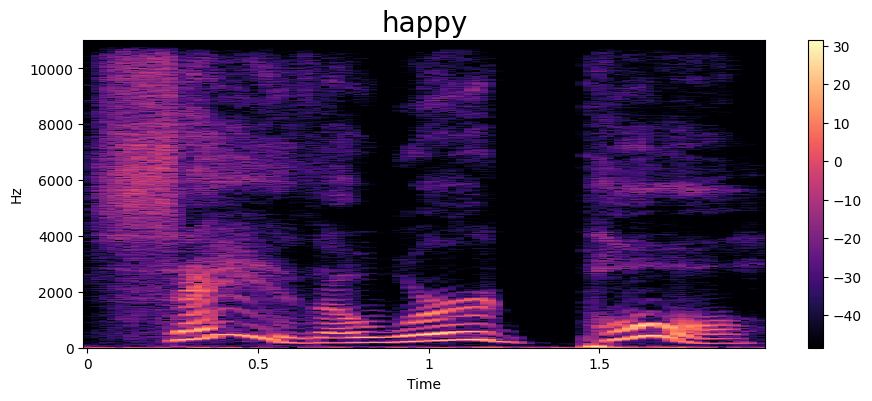

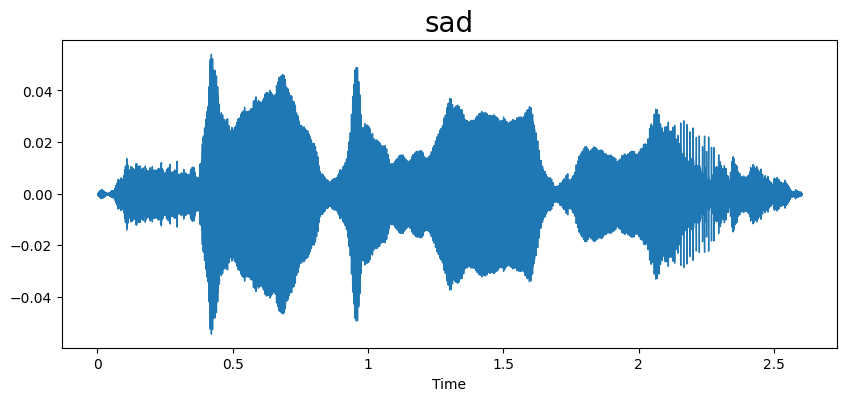

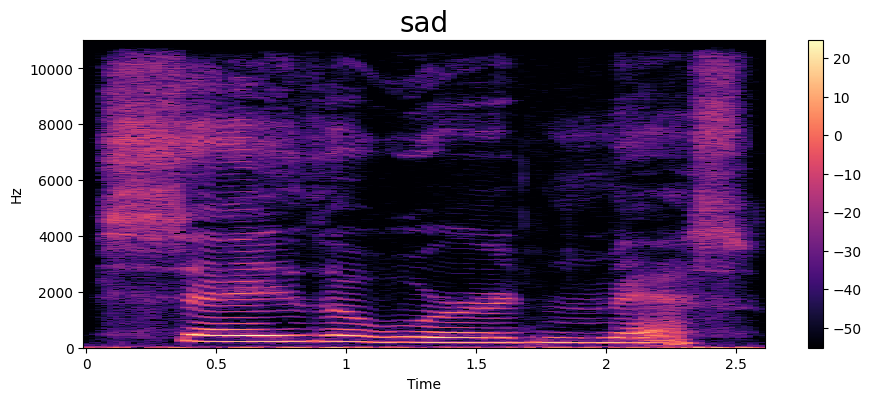

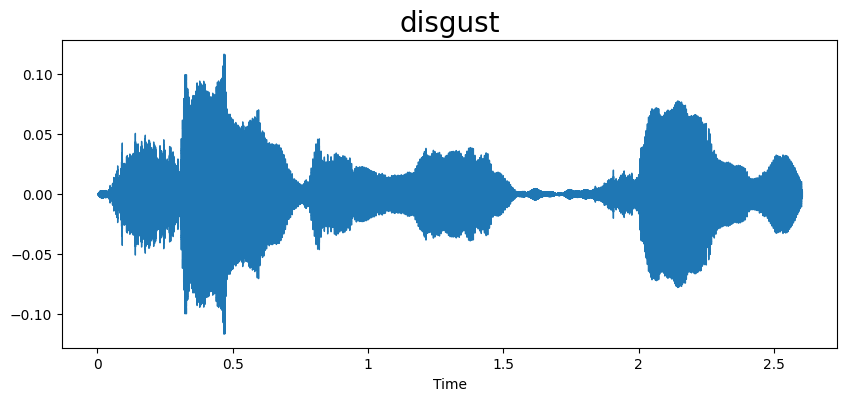

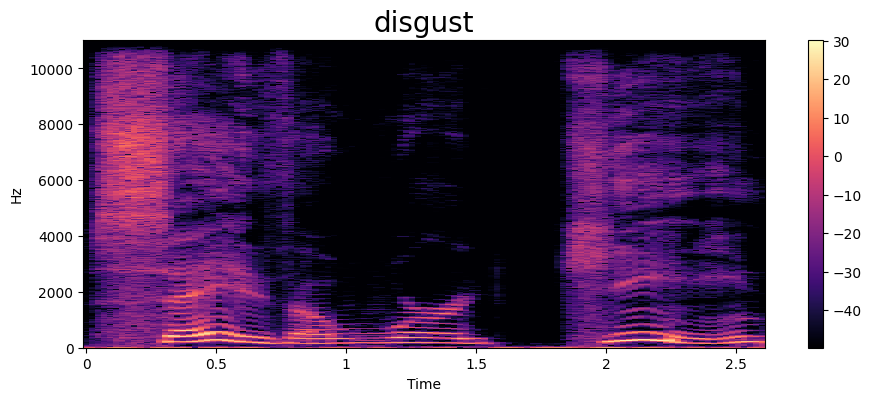

In [2]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

# Display waveplot and spectrogram for each emotion
emotions = df['label'].unique()
for emotion in emotions:
    path = np.array(df['speech'][df['label'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectrogram(data, sampling_rate, emotion)
    display(Audio(path))


In [4]:
from keras.utils import to_categorical

def extract_features(file_name):
    # Load the audio file
    audio, sample_rate = librosa.load(file_name)
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Scale the MFCC features
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# Extract features for all audio files
df['features'] = df['speech'].apply(extract_features)
X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

# Encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)



# Convert to categorical
y = to_categorical(y, num_classes=len(np.unique(y)))



In [5]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from keras.optimizers import Adam

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, shuffle=True)


Epoch 1/50
28/28 [==============================] - 5s 57ms/step - loss: 1.9966 - accuracy: 0.1440 - val_loss: 1.8896 - val_accuracy: 0.1585
Epoch 2/50
28/28 [==============================] - 0s 12ms/step - loss: 1.8595 - accuracy: 0.2467 - val_loss: 1.7627 - val_accuracy: 0.4286
Epoch 3/50
28/28 [==============================] - 0s 13ms/step - loss: 1.7437 - accuracy: 0.3488 - val_loss: 1.6485 - val_accuracy: 0.6250
Epoch 4/50
28/28 [==============================] - 0s 12ms/step - loss: 1.6100 - accuracy: 0.4660 - val_loss: 1.5075 - val_accuracy: 0.7455
Epoch 5/50
28/28 [==============================] - 0s 12ms/step - loss: 1.4638 - accuracy: 0.5798 - val_loss: 1.3548 - val_accuracy: 0.8147
Epoch 6/50
28/28 [==============================] - 0s 11ms/step - loss: 1.3044 - accuracy: 0.6747 - val_loss: 1.1940 - val_accuracy: 0.8504
Epoch 7/50
28/28 [==============================] - 0s 12ms/step - loss: 1.1293 - accuracy: 0.7645 - val_loss: 1.0437 - val_accuracy: 0.8571
Epoch 8/50
28

18/18 [==============================] - 3s 4ms/step - loss: 0.0714 - accuracy: 0.9946
Accuracy: 99.46%


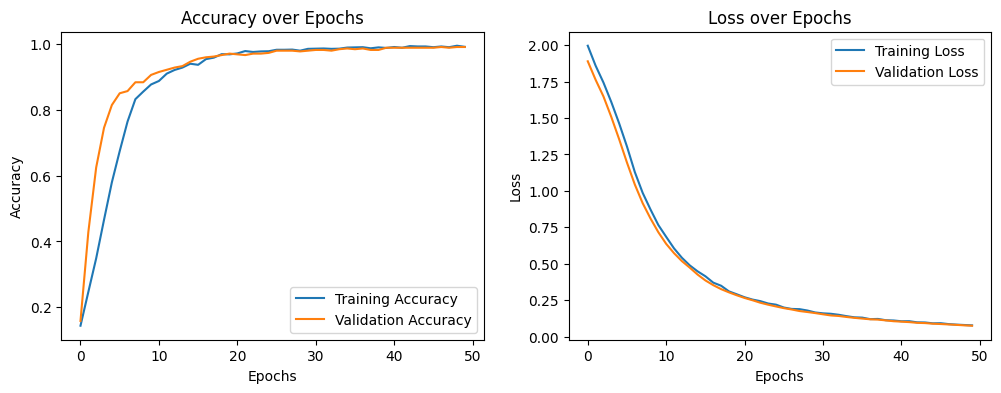

In [6]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
